In [1]:
%load_ext autoreload
%autoreload 2
import os.path as osp
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import h5py
from data_utils import *
import sys

sys.path.append('/home/tau/emenier/workspace/miniGPT/')
import miniGPT
data_dir = '/home/tau/emenier/data/AirfRANS/Dataset/'
outfile = 'formatted_AirfRANS.h5'

/home/tau/emenier/miniconda3/envs/Fin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = H5RansDataset(osp.join(data_dir,outfile))
dataset = H5RansDataset(osp.join(data_dir,outfile))



savedir = '/home/tau/emenier/data/AirfRANS/runs/run_1'

batch_size = 64 # how many independent sequences will we process in parallel?
lr = 3e-4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
P = 16
C = 1
D = 768
image_size = dataset.N
C_out = 2
n_layers = 12
n_heads = 8
dropout = 0.1
N = image_size**2//(P**2)

print(f'D : {D:}, n_head : {n_heads:}, n_layer : {n_layers:}')

train_dataset = RansPatchDataset(dataset,P,
                indices=np.arange(9*len(dataset)//10))
val_dataset = RansPatchDataset(dataset,P,
                indices=np.arange(9*len(dataset)//10,len(dataset)))



generator_vit = miniGPT.ViT.GeneratorViT(P, C, D, C_out, n_layers, n_heads, 
                    N, dropout_freq=0.,
                    gpus_to_split=None).cuda()

trainer = AirfRANSGPTtrainer(generator_vit,lr,
                    checkpoint_path=savedir,wd=0.,parallel=True)


D : 768, n_head : 8, n_layer : 12


Model Numbers : 
   Context   :  256 tokens
   Embedding :  768 tokens
   Layers    :   12
   Heads     :    8
   Params    : 86 M


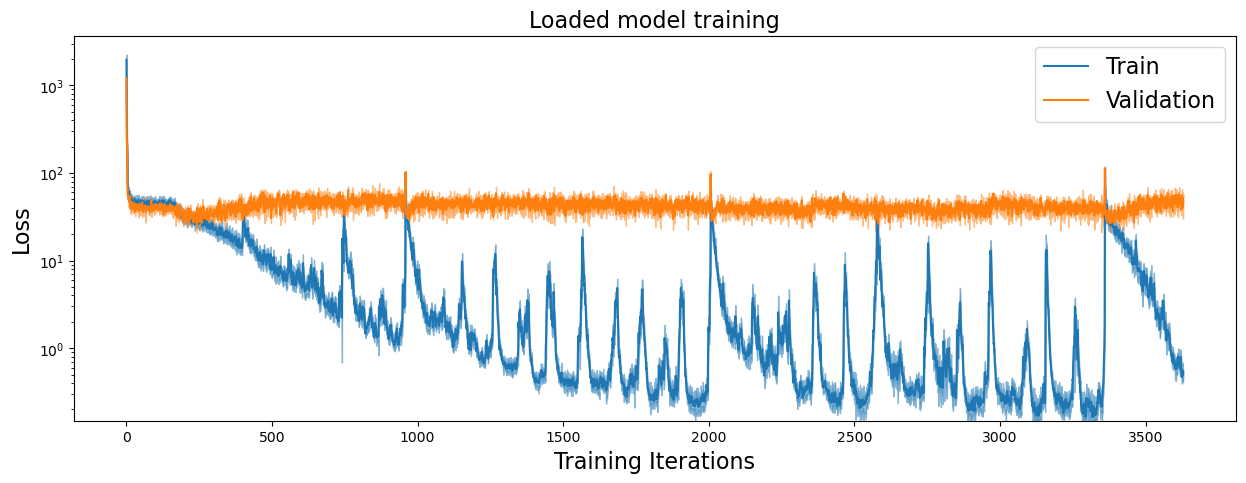

In [3]:
dic = trainer.load('last_model.trch')
trainer.gpt_model.eval()
miniGPT.plot_utils.model_numbers(generator_vit,N,n_layers,D, n_heads)
miniGPT.plot_utils.plot_losses(dic)

In [19]:
loader = miniGPT.train_utils.MyLoader(val_dataset,2,len(dataset)//2,torch.device('cpu'))


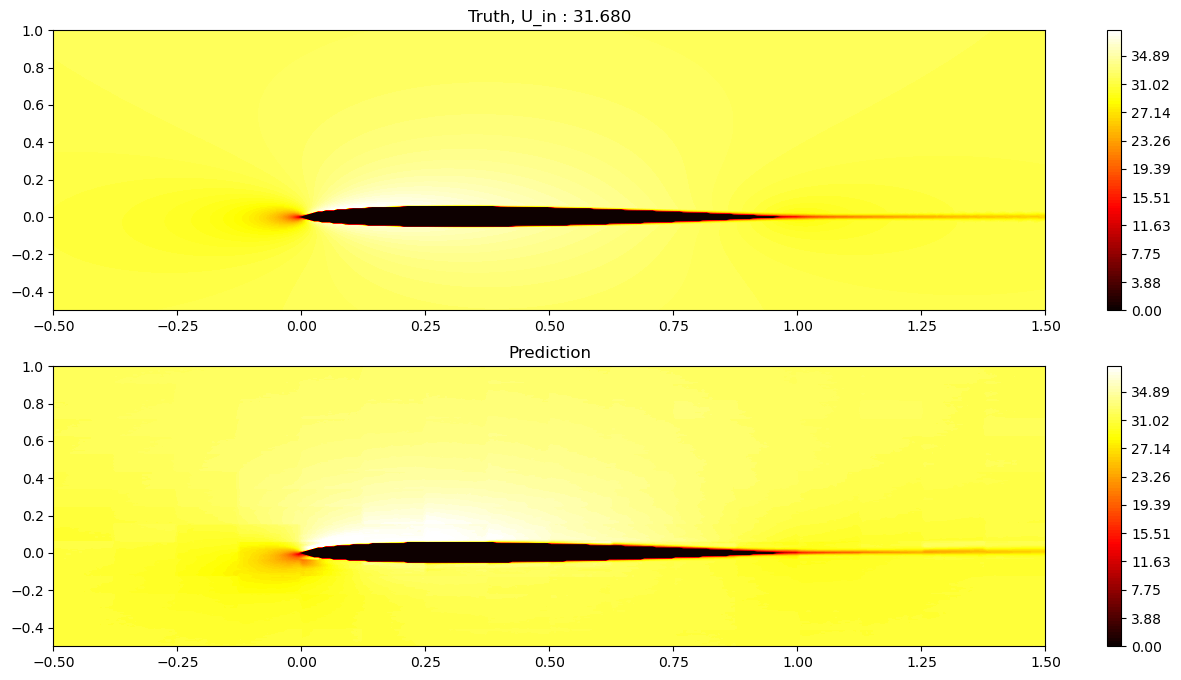

In [20]:

patches_in, patches_out, mask = next(loader)
pred = generator_vit.predict(patches_in.cuda(),mask)
uvals = to_img(patches_out,dataset.N,dataset.N,P).detach().cpu().numpy()
uvals = np.linalg.norm(uvals,axis=1)[0]
predvals = to_img(pred,dataset.N,dataset.N,P).detach().cpu().numpy()
predvals = np.linalg.norm(predvals,axis=1)[0]
geom = to_img(patches_in[...,1:],dataset.N,dataset.N,P).detach().cpu().numpy()[0,0]
x = np.linspace(-0.5,1.5,dataset.N)
y = np.linspace(-0.5,1,dataset.N)

levels= np.linspace(uvals.min(),uvals.max(),100)

fig, (ax1,ax2) = plt.subplots(nrows=2,figsize=(16,8))
ax1.set_title(f'Truth, U_in : {patches_in[0,0,0].item():.3f}')
ola = ax1.contourf(x, y, uvals, 100, levels=levels,cmap=plt.cm.hot)
cbar = plt.colorbar(ola)
ax2.set_title('Prediction')
ola = ax2.contourf(x, y, predvals, 100, levels=levels,cmap=plt.cm.hot)
cbar = plt.colorbar(ola)